# Data Normalization & Classification: 
# Police Violence in North America

### Workshop/Lecture by June Skeeter

# Learning Outcomes:
1) Investigate how data normalization impacts the way we perceive patterns in a dataset

2) Look at different data classification methods and how they impact the way we perceive patterns in a dataset
    
* A) Revisit measurement scales, how are they related to classification methods?
* B) Choropleth mapping

# Content Warning:
* This lecture/workshop deals with a difficult and painful subject that may be triggering to some people.  The datasets we're using today describe incidents of police killings in Canada and the United States

# Pre-Lecture Poll questions:

### 1) Which country has a higher frequency of police violence?
    A) Canada
    B) The United States
    C) They're about equal
    
### 2) Which country has a greater racial disparity in incidetns of police violence?
    A) Canada
    B) The United States
    C) They're about equal

In [2]:
## This module aggregates the data into a format that's easy for us to work with
import ParseData
import numpy as np
import pandas as pd
import scipy.stats as stats
## We'll use maptloltib to make some plots
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pytablewriter
%matplotlib notebook
## Calling "GetData" does all of our prepprocessing
Data = ParseData.GetData()

# Canadian Police Violence Data


This data was collected by the CBC and is available for download here: 
    https://newsinteractives.cbc.ca/fatalpoliceencounters/
    
* "There is no government database listing deaths at the hands of the police available to the public in Canada, so CBC News created its own. The CBC’s research librarians have collected detailed information on each case, such as ethnicity, the role of mental illness or substance abuse, the type of weapon used and the police service involved, to create a picture of who is dying in police encounters. "
    
    
* This is not an official count because police departments in Canada are not mandated to collect all of this information.  Rather this dataset is a collection of second hand information in the form of press releases, news articles, etc.  Some records are incomplete, and the total number of incidents is likely higher than detailed here.

# 1) Police killings by year
* There were 556 killings between January 2000 - June 2020
    * Increasing trend0.85 killings/year.
    * 2020 is on pace to be a record breaking year.

In [3]:
CA_Total=Data.CA_PoliceKillings['PROV'].count()
print('Total Police Killings in Canada: Jan 2000 - June 2020: '+str(CA_Total.sum()))
ByYear=Data.CA_PoliceKillings.resample('YS').count()['PROV']

# print(ByYear.index,ByYear.values)

LR = stats.linregress(ByYear.index.year,ByYear.values)
print(LR)


fig,ax=plt.subplots(1,1)
ax.set_title('Police Killings by Year',loc='left')
ax.bar(ByYear.index.year,ByYear.values,color=[1,0,0],edgecolor='k',label='Total Jan-Dec')
ax.bar([2020],[ByYear.values[-1]],color=[1,.5,.5],edgecolor='k',label='Total Jan-Jun')
ax.plot(ByYear.index.year,ByYear.index.year*LR[0]+LR[1],
        color='k',label = 'Trend Line: '+str(np.round(LR[0],2))+' killings per year')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('Content/CA_Trendline.png')

Total Police Killings in Canada: Jan 2000 - June 2020: 556
LinregressResult(slope=0.8532467532467533, intercept=-1688.5497835497836, rvalue=0.7527826321554801, pvalue=8.225541264933506e-05, stderr=0.17117162472122704)


<IPython.core.display.Javascript object>

# 2) Age distribution of victims

Histograms show the shape and spread of a dataset.
* Here we see the age distribution of victims in 5 year increments.
    * The youngest was 15 and the oldest was 77
    * The mean age is 35.6, the standard deviation is 11.6
* The histogram shows us that the age is slightly skewed towards older ages
    * The distribution has a tail

In [4]:
print(Data.CA_PoliceKillings['AGE'].describe())

fig,ax=plt.subplots(1,1)
Data.CA_PoliceKillings['AGE'].hist(bins = np.arange(15,80,5),color=[1,0,0],edgecolor='k',ax=ax)
plt.axvline(Data.CA_PoliceKillings['AGE'].mean(), color='k', linestyle='dashed', linewidth=2,label='Mean')
plt.axvline(Data.CA_PoliceKillings['AGE'].mean()+Data.CA_PoliceKillings['AGE'].std(), 
            color='b', linestyle='dashed', linewidth=2,label='1 Standard Deviation')
plt.axvline(Data.CA_PoliceKillings['AGE'].mean()-Data.CA_PoliceKillings['AGE'].std(), 
            color='b', linestyle='dashed', linewidth=2)
# plt.axvline(Data.CA_PoliceKillings['AGE'].quantile(.25), color='b', linestyle='dashed', linewidth=1)
# plt.axvline(Data.CA_PoliceKillings['AGE'].quantile(.25), color='b', linestyle='dashed', linewidth=1)
ax.set_title('Age of Victims',loc='left')
plt.legend()
plt.tight_layout()
plt.savefig('Content/CA_AgeHist.png')


count    540.000000
mean      36.527778
std       11.719082
min       15.000000
25%       27.000000
50%       35.000000
75%       44.000000
max       77.000000
Name: AGE, dtype: float64


<IPython.core.display.Javascript object>

# 3) What type of weapon (if any) did the victim have?
* Nearly 30% of victims were unarmed.
    * Note - Being Armed is does not justify any individual police killing.
    * However, in aggregate a higher number of killings of unarmed people can indicate a predisposition towards excessive use of force.

In [5]:
fig,ax=plt.subplots(1,1)
ax.set_title('Weapon Type',loc='left')
Weaopn_Type=Data.CA_PoliceKillings.groupby('ARMED TYPE').count()['AGE'].sort_values()
ax.pie(Weaopn_Type.values,labels=Weaopn_Type.index,
    autopct='%1.1f%%')
plt.tight_layout()
plt.savefig('Content/CA_Weapon.png')

<IPython.core.display.Javascript object>

In [6]:
# Data.CA_PoliceKillings.RACE.fillna('Unknown',inplace=True)
Cat = 'ARMED TYPE'
Departments=Data.CA_PoliceKillings.groupby(['POLICE SERVICE','PROV',Cat]).count()['SUMMARY'].unstack()
Departments=Departments.reset_index().set_index('POLICE SERVICE')
Departments=Departments.fillna(value=0)

Departments['Total'] = Departments[Data.CA_PoliceKillings[Cat].unique()].sum(axis=1)

Departments['NAME']=Departments.index
Departments['NAME']=Departments['NAME'].str.replace(' Department','')
Departments['NAME']=Departments['NAME'].str.replace(' Services','')
Departments['NAME']=Departments['NAME'].str.replace(' Service','')
Departments['NAME']=Departments['NAME'].str.replace(' Force','')
Departments['NAME']=Departments['NAME'].str.replace('Service de police de la Ville de ','')
Departments['NAME']=Departments['NAME'].str.replace('Service de la sécurité publique de ','')
Departments['NAME']=Departments['NAME'].str.replace('Service de police de ','')
Departments['NAME']=Departments['NAME'].str.replace('Régie intermunicipale de police ','')
Departments['NAME']=Departments['NAME'].str.replace('Service de sécurité publique de ','')
Departments['NAME']=Departments['NAME'].str.replace('Sécurité publique de ','')

Departments['City']=Departments['NAME'].str.replace('Ontario Provincial Police','')
Departments['City']=Departments['City'].str.replace(' Police','')
Departments['City']=Departments['City'].str.replace('RCMP','')
Departments['City']=Departments['City'].str.replace('Sûreté du Québec','')
Departments['City']=Departments['City'].str.replace(' Regional','')
Departments['City']=Departments['City'].str.replace('Royal Newfoundland Constabulary','')
Departments['City']=Departments['City'].str.replace(' Community','')
Departments['City']=Departments['City'].str.replace('South Coast British Columbia Transit Authority','')
Departments['City']=Departments['City'].str.replace("l'agglomération de ",'')
Departments['City']=Departments['City'].str.replace('du ','')

Departments['TYPE']='Municipal/Regional'
# Departments.loc[Departments.index.str.contains('Regional')==True,'TYPE']='Regional'
# Departments.loc[Departments.index.str.contains('Toronto')==True,'TYPE']='Regional'
# Departments.loc[Departments.index.str.contains("Service de police de l'agglomération de ")==True,'TYPE']='Regional'
# Departments.loc[Departments.index.str.contains('Transit Authority Police Service')==True,'TYPE']='Regional'
# Departments.loc[Departments.index.str.contains('Régie intermunicipale de police')==True,'TYPE']='Regional'
# Departments.loc[Departments.index.str.contains('Service de police de la Ville de Montréal')==True,'TYPE']='Regional'
Departments.loc[Departments.index.str.contains('RCMP')==True,'TYPE']='RCMP'
Departments.loc[Departments.index.str.contains('Ontario Provincial Police')==True,'TYPE']='Provincial'
Departments.loc[Departments.index.str.contains('OPP')==True,'TYPE']='Provincial'
Departments.loc[Departments.index.str.contains('Sûreté du Québec')==True,'TYPE']='Provincial'
Departments.loc[Departments.index.str.contains('Royal Newfoundland Constabulary')==True,'TYPE']='Provincial'

writer = pytablewriter.MarkdownTableWriter()
writer.table_name = "10 Deadliest Police Departments"
writer.header_list = ["Department","Provnce", "Killings"]
TB = Departments.sort_values(by='Total',ascending=False)[0:10]
writer.value_matrix = [[index,value['PROV'],value['Total']]for index,value in TB.iterrows()]
# list(Departments.groupby('TYPE').count()['NAME'])
#     ["1", "AD", "Europe/Andorra"],
#     ["2", "AE", "Asia/Dubai"],
#     ["3", "AF", "Asia/Kabul"],
#     ["4", "AG", "America/Antigua"],
#     ["5", "AI", "America/Anguilla"],
# ]
# print(Departments.head())
writer.write_table()


# 10 Deadliest Police Departments
|               Department                |Provnce|Killings|
|-----------------------------------------|-------|-------:|
|RCMP                                     |BC     |      78|
|Toronto Police Service                   |ON     |      56|
|Service de police de la Ville de Montréal|QC     |      35|
|Sûreté du Québec                         |QC     |      34|
|RCMP                                     |AB     |      33|
|Edmonton Police Service                  |AB     |      27|
|Ontario Provincial Police                |ON     |      27|
|Calgary Police Service                   |AB     |      26|
|Vancouver Police Department              |BC     |      24|
|Winnipeg Police Service                  |MB     |      21|


In [7]:
from geopy.geocoders import MapBox
import geopandas as gpd
api_key="pk.eyJ1IjoianVuZXNwYWNlYm9vdHMiLCJhIjoiY2s4a285NTM1MDQwbDNocHozdXlkNzIyaSJ9.-_8gh9gG4VuprIPnmXBr3A"

geolocator = MapBox(api_key=api_key)

# print(Departments)

Departments['Lat']=np.nan
Departments['Lon']=np.nan
Departments['Geocoding_notes']=''

for index,Service in Departments.sort_values(by='Total',ascending=False).iterrows():
    try:
        Point = geolocator.geocode(Service.NAME+', '+Service.City+', '+Data.can_province_names[Service.PROV]+', Canada')#,exactly_one=False)
        Departments.loc[((Departments.NAME==Service.NAME)&(Departments.PROV==Service.PROV)),['Lat','Lon']]=[Point.latitude,Point.longitude]
#     print(index+', '+Data.can_province_names[Service.PROV],Point.latitude,Point.longitude)
    except:
        Departments.loc[((Departments.NAME==Service.NAME)&(Departments.PROV==Service.PROV)),'Geocoding_notes']='Geocoding Failed'
        pass



Departments_GPD = gpd.GeoDataFrame(Departments,
    geometry=gpd.points_from_xy(Departments.Lon,
                                Departments.Lat
                               ) )

# Now we can assign a CRS
WGS_1984={'init' :'epsg:4326'}
Departments_GPD.crs = WGS_1984
Departments_GPD = Departments_GPD.to_crs(Data.CA.crs)
print('Done')

C:\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Done


In [11]:
Municipal_Deparments = Departments_GPD.loc[Departments_GPD['TYPE']=='Municipal/Regional']

# print(Municipal_Deparments)

Temp = (gpd.sjoin(Data.Municipal_Boundaries,Municipal_Deparments,lsuffix='Pop',rsuffix='Killings'))
# print(Municipal_Boundaries.count()[0],Municipal_Deparments.count()[0],Temp.count()[0])
# print(Departments_GPD['TYPE'])
Cats = Data.CA_PoliceKillings[Cat].unique()
# Departments_GPD

In [15]:
# from geopy.geocoders import MapBox
import folium
# # from IPython.display import clear_output

# api_key = "pk.eyJ1IjoianVuZXNwYWNlYm9vdHMiLCJhIjoiY2s4a285NTM1MDQwbDNocHozdXlkNzIyaSJ9.-_8gh9gG4VuprIPnmXBr3A"

def plot_point(Map,X,Y,Popup_Text,Color='olive',Radius=5,Opacity=.75,LineColor='black',LineWidth=.15):
    folium.CircleMarker(
        # The coordiatnates
        location=[X,Y],
        # Text description
        popup=Popup_Text,
        # sets the fill color for the point
        fill_color=Color,
        # Size of the marker
        radius=Radius,
        # Opacity of the circle
        fill_opacity = Opacity,
        # Sets the line color for the edge
        color=LineColor,
        # Width of the border line
        line_weight=LineWidth,
    ).add_to(Map)

Scale,Offset=.5,1
    
Final_Map = folium.Map(
    location=[60,-91.5],
    zoom_start=3,
    tiles='Stamen Toner'
)

group0 = folium.FeatureGroup(name='RCMP')
group1 = folium.FeatureGroup(name='Provincial Police Forces')
group2 = folium.FeatureGroup(name='Municipal/Regional Police Forces')
for index, row in Departments_GPD.iterrows():
#     if row['geocoding_Notes'] != 'Geocoding Failed':
        
        # ''' indicates we're wrting multiline strings
        # We'll write the header and the top row of the table
        popuptext='''<body> <h2>'''+index+'''</h2> 
                    <table style="width:100%">
                    <tr>
                    <th>Race</th>
                    <th>Number of Killings &nbsp </th>
                    <th>Percentage of Total</th>
                    </tr>
                     '''
        
        # We'll sort each row by race so the largest appears at the top of the table
        Sorted = row[Cats].sort_values(ascending=False)
        for i,v in zip(Sorted.index,Sorted.values):
            if (np.isnan(v)==False) and (v>0):
                if np.isnan(v)==False:
                    # If the value for a race exists, we'll add it to the table
                    popuptext+= '''<tr>
                                <td>'''+i+''' &nbsp </td>
                                <td>'''+str(int(v))+'''</td>
                                <td>'''+str(int(v/row['Total']*100))+'''%</td>
                                </tr>'''
    #         We'll add row at the bottom of the table with the total


        popuptext+='''<tr>
                      <th>Total </th>
                      <th>'''+str(row['Total'])+'''</th>
                      <th> </th>
                      </tr>'''
        
        # We'll convert the text tot html
        test = folium.Html(popuptext, script=True)
        
        # This defines the parameters for the popup text box
        popup = folium.Popup(test, max_width=400,min_width=300)
        
#         # Now we can send the popup to the CircleMarker
        if row['TYPE']=='RCMP':
            plot_point(Map=group0,
                       X=row.Lat,#['latitude'],
                       Y=row.Lon,#['longitude'],
                       Popup_Text=popup,
                       # This is hexcode for the official red of Canada
                       Color='#FF0000',
                       # We'll scale the radius by the number of killings + 2
                       Radius=(row['Total'])*Scale+Offset,
                      )
            
        elif row['TYPE']=='Provincial':
            plot_point(Map=group1,
                       X=row.Lat,#['latitude'],
                       Y=row.Lon,#['longitude'],
                       Popup_Text=popup,
                       # This is hexcode for the official red of Canada
                       Color='#9400D3',
                       # We'll scale the radius by the number of killings + 2
                       Radius=(row['Total'])*Scale+Offset,
                      )
        else:
            plot_point(Map=group2,
                   X=row.Lat,#['latitude'],
                   Y=row.Lon,#['longitude'],
                   Popup_Text=popup,
                   # This is hexcode for the official red of Canada
                   Color='#0000ff',
                   # We'll scale the radius by the number of killings + 2
                   Radius=(row['Total'])*Scale+Offset,
                  )
group0.add_to(Final_Map)

group1.add_to(Final_Map)

group2.add_to(Final_Map)


    
folium.LayerControl().add_to(Final_Map)
    
Final_Map.save('Content/PoliceViolenceIncidents.html')
Final_Map


# 5) The racial breakdown of police killings.
* The majority of police killings are white people
    * The second largest demographic is "Unknown", which in most cases means the this information was not recorded by the police.  Since this data was collected and reported by a third party rather through a central database, information is missing.  This information should be mandatory for police departments to collect and publish.
* Demographic groups are not evenly represented in the populations
    * Canada is about 73.4% White while its only 4.7% Indigenous and 3.4% Black


0.034096332333932486
                                0
Visible minority, n.i.e    364460
Unknown                         0
White                    25803358
Black                     1198545
Asian                     3216380
Indigenous                1673780
South Asian               1924640
Arab                       523235
Latin American             447330


<IPython.core.display.Javascript object>


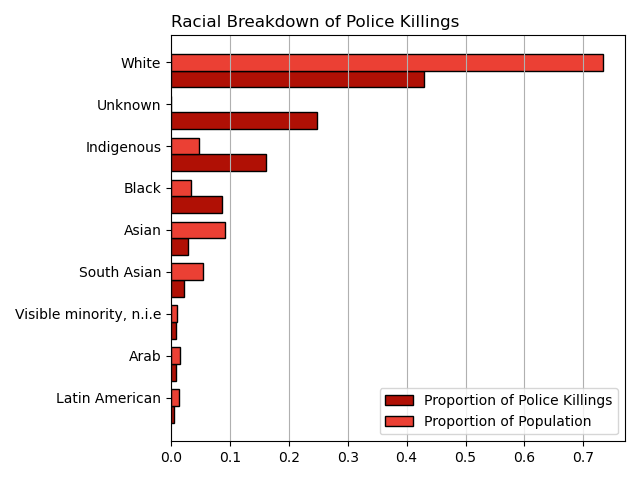

                             PROV         0
RACE                                       
Latin American           0.005396  0.012726
Arab                     0.008993  0.014885
Visible minority, n.i.e  0.008993  0.010368
South Asian              0.021583  0.054752
Asian                    0.028777  0.091500
Black                    0.086331  0.034096
Indigenous               0.161871  0.047616
Unknown                  0.248201  0.000000
White                    0.429856  0.734057


In [62]:
print(Data.CA.sum()['Black']/Data.CA.sum()['Total'])

Races = (Data.CA_PoliceKillings['RACE'].unique())
Pop = Data.CA[Races].sum().to_frame()
print(Pop)
# print(Data.CA[Data.CA_PoliceKillings['RACE'].unique()])

fig,ax=plt.subplots(1,1)
ax.set_title('Racial Breakdown of Police Killings',loc='left')
ByRace=Data.CA_PoliceKillings.groupby('RACE').count()['PROV'].sort_values()
ByRace=(ByRace/ByRace.sum()).to_frame()
ByRace = ByRace.join(Pop/Pop.sum(),lsuffix='_Pop')
print(ByRace)
# ByRace[['PROV',0]].plot(kind='barh')
ax.barh(np.arange(ByRace.index.shape[0])-.4,ByRace['PROV'].values,color='#b01005',edgecolor='k',
        height=.4,label='Proportion of Police Killings')
ax.barh(np.arange(ByRace.index.shape[0]),ByRace[0].values,color='#eb4034',edgecolor='k',
        height=.4,label='Proportion of Population')
ax.set_yticks(np.arange(ByRace.index.shape[0]))
ax.set_yticklabels(ByRace.index)
ax.grid(axis='x')
ax.legend()
plt.tight_layout()

plt.savefig('Content/CA_Race.png')

### Think about how comparing at the total killings for population groups of very different sizes might impact the way you perceive patterns.  Using this chart, what demographic group do you think is most likely to be killed by the police in Canada?

# 4) Which police departments are responsible for the most killings?
Here are all departments which have killed at least ten people in the last 20 years.
* Provincial police services and large municipal police departments are responsible for the most deaths
* The RCMP serves as the provincial police in eight provinces and the territories.
    * All together, the RCMP is responsible for 34% of deaths 

<IPython.core.display.Javascript object>


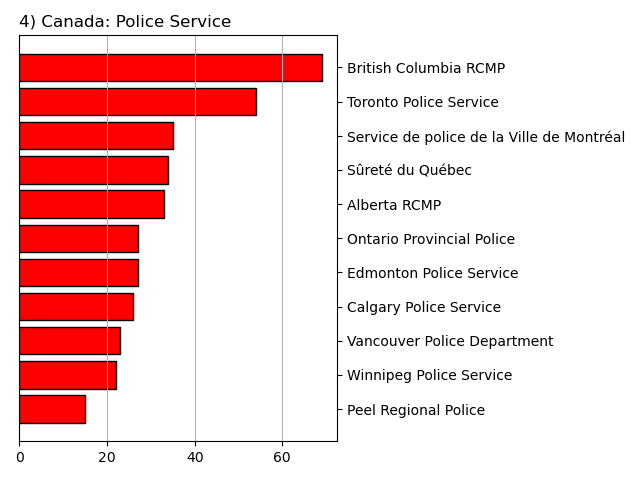

POLICE SERVICE
Peel Regional Police                         0.041096
Winnipeg Police Service                      0.060274
Vancouver Police Department                  0.063014
Calgary Police Service                       0.071233
Edmonton Police Service                      0.073973
Ontario Provincial Police                    0.073973
Alberta RCMP                                 0.090411
Sûreté du Québec                             0.093151
Service de police de la Ville de Montréal    0.095890
Toronto Police Service                       0.147945
British Columbia RCMP                        0.189041
Name: Total, dtype: float64


In [10]:
# print(Data.CA.Total.sort_values()/Data.CA.Total.sum())
ARMED_TYPE=(Data.CA_PoliceKillings.groupby(['POLICE SERVICE','ARMED TYPE']).count()['AGE'].unstack())
# print(ARMED_TYPE)
ARMED_TYPE_RCMP_PROV=(Data.CA_PoliceKillings.loc[Data.CA_PoliceKillings['POLICE SERVICE']=='RCMP'].groupby(['PROV','ARMED TYPE']).count()['AGE'].unstack())
ARMED_TYPE_RCMP_PROV['Name'] = [Data.can_province_names[x] for x in ARMED_TYPE_RCMP_PROV.index]
ARMED_TYPE_RCMP_PROV['POLICE SERVICE']=ARMED_TYPE_RCMP_PROV['Name']+' RCMP'

ARMED_TYPE_RCMP_PROV=ARMED_TYPE_RCMP_PROV.set_index(ARMED_TYPE_RCMP_PROV['POLICE SERVICE'])
# print(ARMED_TYPE_RCMP_PROV)
# print(ARMED_TYPE)

ARMED_TYPE = ARMED_TYPE.loc[ARMED_TYPE.index !='RCMP'].append(ARMED_TYPE_RCMP_PROV)


Types = ARMED_TYPE.columns
ARMED_TYPE['Total']=ARMED_TYPE.sum(axis=1)

fig,ax=plt.subplots(1,1)
ax.set_title('4) Canada: Police Service',loc='left')
# ByRace=Data.CA_PoliceKillings.groupby('POLICE SERVICE').count()['AGE'].sort_values()[-10:]
ARMED_TYPE = ARMED_TYPE.loc[ARMED_TYPE['Total']>10].sort_values(by='Total')
ax.barh(ARMED_TYPE.index,ARMED_TYPE['Total'].values,color=[1,0,0],edgecolor='k')
# ax.yaxis.set_tick_params(pad=160)
# ax.set_yticklabels(ARMED_TYPE.index, ha = 'left')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
plt.grid(axis='x')
plt.tight_layout()
plt.savefig('Content/CA_PoliceServices.png')


print(ARMED_TYPE['Total']/ARMED_TYPE['Total'].sum())
# fig,ax=plt.subplots(1,1)
# RCMP = Data.CA_PoliceKillings.loc[Data.CA_PoliceKillings['POLICE SERVICE']=='RCMP'].groupby('PROV').count().sort_values(by='RACE')
# ax.set_title('6) RCMP: By Province',loc='left')
# # ARMED_TYPE = ARMED_TYPE.loc[ARMED_TYPE['Total']>10].sort_values(by='Total')
# ax.barh(RCMP.index,RCMP['RACE'].values,color=[1,0,0],edgecolor='k')
# plt.tight_layout()




# Data Normalization

Normalization, is the process of scaling (AKA Normalizing) one number by another.
* For example, we can as the question:
    * Which police departments are most likely to kill an unarmed person?
* We need two pieces of information for each police department
    * A) The total unarmed victims
    * B) The total victims
* We can divide A by B, this will tell us what percentage of each departments victims were unarmed.
* So our normalization calculation would look like:

    
\begin{align}
\ Percent Unarmed & = (\frac{Unarmed Victims}{Total Victims})* 100 \\
\end{align}

This shows different patterns in the data that are easy to overlook when using raw counts
* Nearly half the people killed by BC RCMP did not have a weapon
    * Vancouver Police are the fourth most likely to kill an unarmed person.  Nearly 40% of their victims are unarmed.
    * Killing of unarmed people by police in our region is a severe problem.
    
# This information should be widely known and available.  The RCMP and other Police Services across Canada need to be held accountable.

<IPython.core.display.Javascript object>


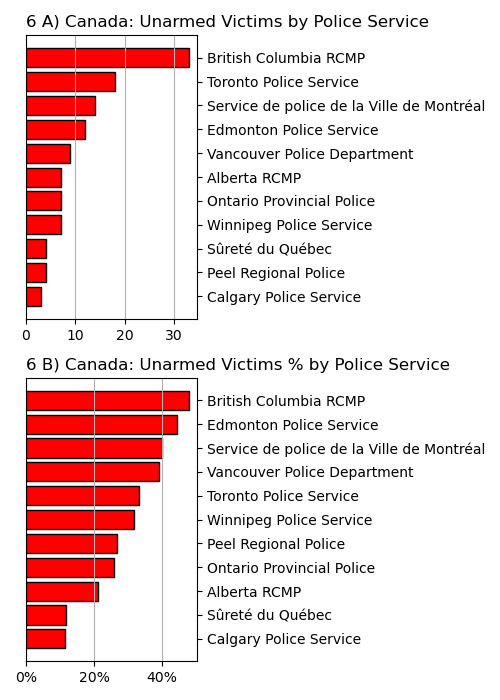

In [11]:
import matplotlib.ticker as mtick
ARMED_TYPE['Unarmed%']=ARMED_TYPE['None']/ARMED_TYPE['Total']*100
ARMED_TYPE = ARMED_TYPE.fillna(0)
fig,ax=plt.subplots(2,1,figsize=(5,7))

ax[0].set_title('6 A) Canada: Unarmed Victims by Police Service',loc='left')
ARMED_TYPE = ARMED_TYPE.loc[ARMED_TYPE['Total']>10].sort_values(by='None')
ax[0].barh(ARMED_TYPE.index,ARMED_TYPE['None'].values,color=[1,0,0],edgecolor='k')
ax[0].yaxis.tick_right()
ax[0].grid(axis='x')

ax[1].set_title('6 B) Canada: Unarmed Victims % by Police Service',loc='left')
ARMED_TYPE = ARMED_TYPE.loc[ARMED_TYPE['Total']>10].sort_values(by='Unarmed%')
ax[1].barh(ARMED_TYPE.index,ARMED_TYPE['Unarmed%'].values,color=[1,0,0],edgecolor='k')
ax[1].yaxis.tick_right()
ax[1].xaxis.set_major_formatter(mtick.PercentFormatter())
ax[1].grid(axis='x')
plt.tight_layout()
plt.savefig('Content/CA_UnarmedFraction.png')

In [79]:

# # print(Departments.loc[Departments.index==index])
# # # print(index)
# # print(index[0]+', '+Service.PROV)
# # plt.figure()
# # plt.scatter(Departments.Lon,Departments.Lat)
# # print(Departments)

# fig,ax=plt.subplots()
# # print(Departments_GPD.loc[Departments_GPD.Lat==Departments_GPD.Lat.max()])
# # Data.CA.plot(ax=ax)
# Dis=Municipal_Boundaries.dissolve(by='CDNAME',aggfunc='sum')
# Dis.plot(ax=ax)
# Departments_GPD.plot(ax=ax,
#                      color='red',
#                      markersize=Departments_GPD.Total*5,
#                      edgecolor='k')

# # print(Departments)


# Departments_GPD['Discrimination Index'] = (Departments_GPD['White']-Departments_GPD['Indigenous'])/(Departments_GPD['White']+Departments_GPD['Indigenous'])
# # for x, y, label in zip(Departments_GPD.geometry.x, Departments_GPD.geometry.y, Departments_GPD.index):
# #     ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
# Departments_GPD['Discrimination Index'] = Departments_GPD['Discrimination Index']*Departments_GPD['Total']
# print(Departments_GPD['Discrimination Index'].fillna(0).sort_values())

In [80]:
# print(Departments_GPD.sort_values(by='Total'))

# print(Departments_GPD.loc[Departments_GPD.index=='Scarborough Police Service'])
# print(Departments_GPD.loc[Departments_GPD.index=='Toronto Police Service'])
# print()

# Dis=(Municipal_Boundaries[['Total','CDNAME']].sort_values('Total').dropna())
# fig,ax=plt.subplots()
print(Dis['Total'].sort_values()[-20:])

print(Departments.Total.sort_values()[-20:])
# Municipal_Departments = Departments_GPD.loc[((Departments_GPD.index!='RCMP')&(Departments_GPD.index!='OPP'))]
# # print(Municipal_Departments)
# Join = (gpd.sjoin(Municipal_Boundaries,Municipal_Departments.reset_index(),lsuffix='Pop',rsuffix='Killings'))
# Join['Total_Ratio'] = (Join['Total_Killings']/Join['Total_Pop'])*1e6/20
# # print(Join.columns)
# print(Join.sort_values(by='Total_Pop')[['Name','POLICE SERVICE']][-25:])

CDNAME
Division No.  1       403275.0
Halifax               403380.0
Longueuil             415347.0
Laval                 422993.0
Niagara               447888.0
Middlesex             455526.0
Simcoe                479650.0
Waterloo              535154.0
Hamilton              536917.0
Halton                548435.0
Québec                569717.0
Durham                645862.0
Ottawa                934243.0
York                 1204570.0
Peel                 1381739.0
Division No.  6      1806073.0
Montréal             1942044.0
Division No. 11      2380854.0
Greater Vancouver    2463431.0
Toronto              2731571.0
Name: Total, dtype: float64
POLICE SERVICE
Saskatoon Police Service                      5.0
London Police Service                         6.0
RCMP                                          6.0
Kativik Regional Police Force                 6.0
RCMP                                          7.0
Hamilton Police Service                       8.0
RCMP                          

<IPython.core.display.Javascript object>


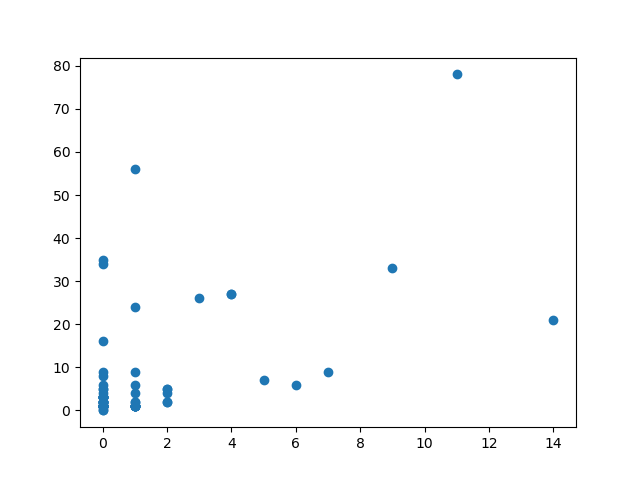

In [18]:
# plt.figure()
# plt.scatter()
Departments['Ratio']=Departments['Indigenous']/Departments['Total']
Departments=Departments.sort_values(by='Indigenous')
# print(Departments[['Ratio','Indigenous','PROV']][-30:])

plt.figure()
plt.scatter(Departments.Indigenous,Departments.Total)
# plt.scatter(Departments.Black,Departments.Total)
# plt.scatter(Departments.White,Departments.Total)

# Departments['Index'] = 


# Departments2 = Data.CA_PoliceKillings.groupby(
#     ['POLICE SERVICE','PROV','RACE']).count().sort_values(by='RACE',ascending=False).unstack()
# print(Departments2.reset_index().set_index('POLICE SERVICE'))

# Questions:

What are some other applications for data normalization?

What metric(s) might you want consider when looking at total number of electric cars in each province to gauge electirc car adoption?

A) Kilometers driven
B) Cars per family
C) Median Income
D) Total Population
E) Average Car Price

# The United States Data
 
The United States Data is colected by a colaboration of researchers and data scientists and is availble for download here: https://mappingpoliceviolence.org/

"We believe the data represented on this site is the most comprehensive accounting of people killed by police since 2013. Note that the Mapping Police Violence database is more comprehensive than the Washington Post police shootings database: while WaPo only tracks cases where people are fatally shot by on-duty police officers, our database includes additional incidents such as cases where police kill someone through use of a chokehold, baton, taser or other means as well as cases such as killings by off-duty police."

This is not an official count.
* This dataset is a collection of second hand information in the form of press releases, news articles, etc.
* Some records are incomplete, and the total number of incidents is likely higher than detailed here.

In [ ]:
US_Total=Data.US_PoliceKillings["State"].count()

print(Data.US_PoliceKillings["AGE"].describe())

fig,ax=plt.subplots(2,2,figsize=(8,6))
ax[0,0].set_title('1) Police Killings by Year',loc='left')
ByYear=Data.US_PoliceKillings.resample('YS').count()['AGE']
ax[0,0].bar(ByYear.index.year,ByYear.values,color=[0,0,1],edgecolor='k')
ax[0,0].bar([2020],[ByYear.values[-1]],color=[.5,.5,1],edgecolor='k')
# plt.tight_layout()

ax[0,0].grid(axis='y')
# plt.savefig('Content/US_ByYear.png')

# fig,ax=plt.subplots(1,1)
ax[1,0].set_title('3) Race',loc='left')
ByRace=Data.US_PoliceKillings.groupby('RACE').count()['AGE'].sort_values()
ax[1,0].barh(ByRace.index,ByRace.values,color=[0,0,1],edgecolor='k')

ax[1,0].yaxis.tick_right()
ax[1,0].grid(axis='x')

# plt.tight_layout()
# fig,ax=plt.subplots(1,1)
ax[1,1].set_title('4) Armed Type',loc='left')
ByRace=Data.US_PoliceKillings.groupby('Unarmed/Did Not Have an Actual Weapon').count()['AGE'].sort_values()
ax[1,1].pie(ByRace.values,labels=ByRace.index,
    autopct='%1.1f%%')
# plt.tight_layout()



# fig,ax=plt.subplots(1,1)
Data.US_PoliceKillings['AGE'].hist(bins = np.arange(0,110,5),color=[0,0,1],edgecolor='k',ax=ax[0,1])
ax[0,1].set_title('2) Age Distribution of Victims')
ax[0,1].grid(axis='x')
plt.tight_layout()



plt.savefig('Content/US_Data.png')



# Part 2) Comparing to the United States  

There are more police killings in the United States than in Canada

* What factors do we need to look at to compare police killings between Canada and the United States?

* The United States has ten times the population of Canada.  If we don't acount for that, our comparsion wont make any sense
    * The graph below is comparing two countries with very different populations and two datasets with different periods of record.

In [ ]:
fig,ax=plt.subplots(figsize=(4,6))
ax.bar([0],CA_Total,color=[1,0,0],label='Canada\n1/2000 - 6/2020')
ax.bar([1],US_Total,color=[0,0,1],label='Unite States\n1/2013 - 8/2020')
ax.set_xticks([0,1])
ax.set_xticklabels(['Canada','Unite States'])
ax.set_title('Police Killings',loc='left')
ax.grid(axis='y')
ax.legend()
plt.tight_layout()
plt.savefig('Content/RawComparison.png')

# What to account for

### A) Record Length
The time periods of these datasets are different
We could only look at the time period when they overlap but, but this would require us to ignore some of the data. 
Alternatively, we can calculate the average number of killings per year.
The data are not from the same periods, but they will be on the same time scale, and they will be as inclusive as possible
### B) Population
The Canada has about 35 million residents.  The US has about 327 million.  
To make the datasets directly comparable, we need to normalize by the total population of each country.  This will allow us to calculate the police killing rate
### C) Scale
Dividing by the population would give us the average number of police killings per person per year.  This will be a very small decimal.  Integers (round numbers) are easier to interpret.  We can divide by the population in millions instead.

# Police Killing Rates
* By normalizing, we can more directly compare the patterns between geographic regions with different characteristics (Population) and datasets of different lenghts

In [ ]:
CA_Rate = CA_Total /(Data.CA.Total.sum()*Data.CA_Length) * 1e6
US_Rate = US_Total /(Data.US.Total.sum()*Data.US_Length) * 1e6

fig,ax=plt.subplots()
ax.bar([0],CA_Rate,color=[1,0,0],label='Canada\n1/2000 - 6/2020')
ax.bar([1],US_Rate,color=[0,0,1],label='Unite States\n1/2013 - 8/2020')
ax.set_xticks([0,1])
ax.set_xticklabels(['Canada','Unite States'])
ax.set_title('Police Killing Rates',loc='left')
ax.set_ylabel('Killings per Million Residents per Year')
ax.legend()


ax.grid(axis='y')
ax.legend()
plt.tight_layout()
plt.savefig('Content/NormalizedComparison.png')

print(US_Rate/CA_Rate)

# Racial Disparities

Systemic Racism is pervasive on both sides of the border

* The police violence dataset and census for each country use different demographic groupings
    * We'll compare the police killing rates of three demographic groups: White, Black, and Indigenous because they are in both datasets.
        * Whites are the majority in both countries, while black and indigenous people disproportionately impacted by police killings on both sides of the border.
* One Caveat, the race of the victim is unknown for 24% of Canadian and 10% of United States.
    * This adds uncertainty to the comparison.  It also means that the Police Killing Rates by race are underestimated, especially for Canada

# Systemic Racism in Policing

* Scaled, to their respective populations, we can see that Indigenous and Black people are much more likely to be killed by the police than white pople in both Canada and the United States
* The overal rates for each race are higher in the US than Canada
    * However the dispartiy between races is actually greater in Canada than the United States
    
* To show this, we can divide the black and indigenous rates fore each country by the white rate.
    * This will tell us how many times more likely a black or indigenous individual is to be killed by the police than a white individual in each country.
    * We can see that Indigenous and Black Canadians are 5.8 and 4.4 times more likely to be killied by police than a White Canadian
        * These disparities are higher than in the US
            * By this metric, you could suggest that police in Canada may be more racially biased than police in the US

In [ ]:
Data.ScaleData(scale=1e6)
print('Police Killing Rates:')
print(Data.Summary)

fig,ax=plt.subplots(figsize=(6,5))
Data.Summary[['US','CA']].plot.barh(color=[[0,0,1],[1,0,0]],edgecolor='k',ax=ax)
ax.set_title('Police Killing Rates')
ax.set_xlabel('Killings per Million Residents per Year')
ax.yaxis.tick_right()
ax.grid(axis='x')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])


plt.tight_layout()
plt.savefig('Content/Racial_Comparison.png')


In [ ]:
Ratio = Data.Summary.loc[Data.Summary.index=='Black']/Data.Summary.loc[Data.Summary.index=='White'].values
Ratio = Ratio.append(Data.Summary.loc[Data.Summary.index=='Indigenous']/Data.Summary.loc[Data.Summary.index=='White'].values)

print(Ratio)
fig,ax=plt.subplots()
Ratio.plot.barh(color=[[0,0,1],[1,0,0]],edgecolor='k',ax=ax)
ax.set_title('Racial Disparites in Police Killings')
ax.set_xlabel('Police Killing Rate Relative to that of White People')
ax.yaxis.tick_right()
ax.grid(axis='x')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])


plt.tight_layout()
plt.savefig('Content/Racial_Disparities.png')
# print(Data.CA.columns)
# Ratio
# RCMP_Race = Data.CA_PoliceKillings.loc[Data.CA_PoliceKillings['RACE']=='Unknown'].groupby('POLICE SERVICE').count()['PROV'].sort_values()
# print(RCMP_Race/RCMP_Race.sum())



# Systemic Racism in Policing is a Canadian Problem

This issue isn't restricted to America, it's pervasive in Canada as well and can not be overlooked. 

* The RCMP were created by Prime Minister John A. Macdonald.  He got the idea for the Mounties from the Royal Irish Constabulary, a paramilitary police force the British created to keep the Irish under control.  Initially called the "North West Mounted Rifles", their primary purpose to clear Indigenous people off their land.  The name was changed to "North-West Mounted Police" because officials in the United States raised concerns that an armed force along the border was a prelude to a military buildup.  This organization was renamed the Royal Canadian Mounted Police in 1904.

# Questions
* Which country is displaying normalized data?
A) Canada
B) The United States
C) Both
D) Neither

In [ ]:
Rate = 'Total'
n_classes=4
Data.Breaks(column='Total_Killings',classes=n_classes,Manual_Bins=[1,4,7,91,175])
Data.US=Data.US.to_crs(Data.CA.crs)

labels=Data.CA[Rate+'_Killings_NB'].unique().sort_values()
colors = []
Grey = .85
for c in range(n_classes):
    colors.append(matplotlib.colors.to_hex([Grey+(c/(n_classes-1)*(1-Grey)),Grey-(c/(n_classes-1)*Grey),Grey-(c/(n_classes-1)*Grey)]))
CA_Color = {key:value for key,value in zip(labels,colors)}
# print(CA_Color)

# import matplotlib
fig,ax=plt.subplots(figsize=(7.5,7.5))
CA_Patches = [matplotlib.text.Annotation('Canada',(0,0))]
for i,klass in enumerate(Data.CA[Rate+'_Killings_NB'].unique().sort_values()):
#     try:
    kwargs = {'facecolor':CA_Color[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':str(np.round(Data.CA_jenks[i],1))+' - '+str(np.round(Data.CA_jenks[i+1],1))}
    if Data.CA.loc[Data.CA[Rate+'_Killings_NB']==klass].count()['PRNAME']>0:
        Data.CA.loc[Data.CA[Rate+'_Killings_NB']==klass].plot(
            ax=ax,
            **kwargs
                 )
    CA_Patches.append(mpatches.Patch(**kwargs))

Data.ScaleData(scale=1e7)
Data.Breaks(column=Rate+'_Rate',classes=n_classes,Manual_Bins=[0,.5,1,2,10])

labels=Data.US[Rate+'_Rate_NB'].unique().sort_values()
colors = []
for c in range(n_classes):
    colors.append(matplotlib.colors.to_hex([Grey-(c/(n_classes-1)*Grey),Grey-(c/(n_classes-1)*Grey),Grey+(c/(n_classes-1)*(1-Grey))]))
US_Color = {key:value for key,value in zip(labels,colors)}

US_Patches = []
# US_Patches.append(mpatches.Patch(**{'facecolor':'None',
#                  'edgecolor':'None',
#                  'linewidth':.5,'label':'United States'}))
for i,klass in enumerate(Data.US[Rate+'_Rate_NB'].unique().sort_values()):
#     try:
    kwargs = {'facecolor':US_Color[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':str(np.round(Data.US_jenks[i],1))+' - '+str(np.round(Data.US_jenks[i+1],1))}
    Data.US.loc[Data.US[Rate+'_Rate_NB']==klass].plot(
        ax=ax,
        **kwargs
             )
    US_Patches.append(mpatches.Patch(**kwargs))
first_legend = plt.legend(handles=CA_Patches, loc='upper left',
      title='Canada: Total Killings 2000-2020')

# Add the legend manually to the current Axes.
plt.gca().add_artist(first_legend)

# Create another legend for the second line.
ax.legend(handles=(US_Patches), loc='lower left',
      title='United States: Annual Killings 2013-2020\nper 10 Million Residents')
    
# ax.legend(handles={'PKR':Patches},) 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# ax.set_title('Police Killings')

plt.tight_layout()
plt.savefig('Content/IsItNormalalized_Map.png',bbox_inches='tight')

# Part 3) Histograms, Data Classification, & Cloropleth Mapping


# Rates by Province/State

Police Killing Rates vary by administrative divisions, e.g. (State/Province)
* If we want to compare rates the first step is to look at histograms.
* A Histogram shows us the frequency distribution of a given variable
    * Data is grouped into a set of bins and counted


In [ ]:
Rate = 'Total'
n_classes=4
Data.Breaks(column=Rate+'_Rate',classes=n_classes,Manual_Bins=[0,.5,1,2,10])
# plt.figure()
import numpy as np
fig,ax=plt.subplots()#1,2)
print(Data.CA['Total_Killings'].describe())
Data.US['Total_Rate'].hist(ax=ax,color=[0,0,1],edgecolor='k')
ax.grid(axis='x')
ax.set_ylabel('Frequency')
ax.set_xlabel('Killings per Million Residents per Year')
ax.set_title('Police Killing Rates by in US States')
ax.axvline(Data.US['Total_Rate'].mean(), color='k', linestyle='dashed', linewidth=2,label='Mean')
ax.axvline(Data.US['Total_Rate'].mean()+Data.US['Total_Rate'].std(), 
            color='r', linestyle='dashed', linewidth=2,label='1 Standard Deviation')
ax.axvline(Data.US['Total_Rate'].mean()-Data.US['Total_Rate'].std(), 
            color='r', linestyle='dashed', linewidth=2)
ax.legend()
plt.savefig('Content/US_Rate_Hist.png')

# Outliers
Histograms can be useful for spotting outliers in a dataset
* The Indigenouos Police Killing rate hisogram for the US shows an outlier
    * Vermont has a rate many times higher than the nearest value

In [ ]:

Data.ScaleData(scale=1e6)
Rate = 'Indigenous'
print(Data.US[Rate+'_Rate'].describe())
fig,ax=plt.subplots()
Data.US[Rate+'_Rate'].hist(color=[0.5,0.5,1],edgecolor='k',bins=10,label='All States')
ax.set_title('Indigenous Police Killing Rates by State in US States')


# ax.axvline(Data.US[Rate+'_Rate'].mean(), color='k', linestyle='dashed', linewidth=2,label='Mean')
# ax.axvline(Data.US[Rate+'_Rate'].mean()+Data.US[Rate+'_Rate'].std(), 
#             color='r', linestyle='dashed', linewidth=2,label='1 Standard Deviation')
# ax.axvline(Data.US[Rate+'_Rate'].mean()-Data.US[Rate+'_Rate'].std(), 
#             color='r', linestyle='dashed', linewidth=2)
# ax.legend()

# plt.tight_layout()
# plt.savefig('Content/US_State_Hist_by_Race.png')


Rate = 'Indigenous'
print(Data.US[Rate+'_Rate'].describe())
# fig,ax=plt.subplots()
Data.US.loc[Data.US[Rate+'_Rate']<50,Rate+'_Rate'].hist(color=[0,0,1],edgecolor='k',bins=10,label='Excluding Vermont')
ax.set_title('Indigenous Police Killing Rates by State')


# ax.axvline(Data.US[Rate+'_Rate'].mean(), color='k', linestyle='dashed', linewidth=2,label='Mean')
# ax.axvline(Data.US[Rate+'_Rate'].mean()+Data.US[Rate+'_Rate'].std(), 
#             color='r', linestyle='dashed', linewidth=2,label='1 Standard Deviation')
# ax.axvline(Data.US[Rate+'_Rate'].mean()-Data.US[Rate+'_Rate'].std(), 
#             color='r', linestyle='dashed', linewidth=2)
ax.legend()
ax.grid(axis='x')
plt.tight_layout()
plt.savefig('Content/US_State_Hist_by_Race.png')


Data.US[Rate+'_Fraction'] = Data.US[Rate]/Data.US['Total']*100
Data.US[[Rate+'_Rate',Rate+'_Killings',Rate,Rate+'_Fraction']].sort_values(Rate+'_Rate',ascending=False).round(3)[:5].reset_index()

# Classification Methods

We'll cover five classification methods

1) Equal Interval
* Data is split to bins of equal width regardless of distribution

2) Quantiles
* Data is split by percentiles

3) Natural Breaks
* Data is split using the Jenks algorithm

4) Standard Deviation
* Data is split to bins based on distance from the mean

5) Manual Breaks
* We define our own splits

# Equal Interval

* The simplest classification scheme is to just break the data into classes of equal sizes
    * e.g. The minimum is .3 and the maximum is 9.8, so we can split that into four bins 2.4 units wide


In [ ]:

Data.ScaleData(scale=1e6)
Rate = 'Total'
Data.Breaks(column=Rate+'_Rate',classes=n_classes,Manual_Bins=[0,.5,1,2,10])

labels=Data.US[Rate+'_Rate_EB'].unique().sort_values()
colors = []
Grey = .85
for c in range(n_classes):
    colors.append(matplotlib.colors.to_hex([Grey+(c/(n_classes-1)*(1-Grey)),Grey-(c/(n_classes-1)*Grey),Grey-(c/(n_classes-1)*Grey)]))
CA_Color = {key:value for key,value in zip(labels,colors)}
# print(CA_Color)

# import matplotlib
fig,ax=plt.subplots(figsize=(7.5,7.5))
CA_Patches = []#[matplotlib.text.Annotation('Canada',(0,0))]

CA_Patches.append(mpatches.Patch(**{'facecolor':'None',
                 'edgecolor':'None',
                 'linewidth':.5,'label':'Canada\n2000-2020'}))
for i,klass in enumerate(Data.US[Rate+'_Rate_EB'].unique().sort_values()):
    try:
        kwargs = {'facecolor':CA_Color[klass],
                 'edgecolor':'black',
                 'linewidth':.5,
                 'label':str(np.round(Data.EB_bins[i],1))+' - '+str(np.round(Data.EB_bins[i+1],1))}
        if Data.CA.loc[Data.CA[Rate+'_Rate_EB']==klass].count()['PRNAME']>0:
            Data.CA.loc[Data.CA[Rate+'_Rate_EB']==klass].plot(
                ax=ax,
                **kwargs
                     )
        CA_Patches.append(mpatches.Patch(**kwargs))
    except:
        pass
    
labels=Data.US[Rate+'_Rate_EB'].unique().sort_values()
colors = []
for c in range(n_classes):
    colors.append(matplotlib.colors.to_hex([Grey-(c/(n_classes-1)*Grey),Grey-(c/(n_classes-1)*Grey),Grey+(c/(n_classes-1)*(1-Grey))]))
US_Color = {key:value for key,value in zip(labels,colors)}

# US_Patches = []dd
CA_Patches.append(mpatches.Patch(**{'facecolor':'None',
                 'edgecolor':'None',
                 'linewidth':.5,'label':'United States\n2013-2020'}))
for i,klass in enumerate(Data.US[Rate+'_Rate_EB'].unique().sort_values()):
    try:
        kwargs = {'facecolor':US_Color[klass],
                 'edgecolor':'black',
                 'linewidth':.5,
                 'label':str(np.round(Data.EB_bins[i],1))+' - '+str(np.round(Data.EB_bins[i+1],1))}
        Data.US.loc[Data.US[Rate+'_Rate_EB']==klass].plot(
            ax=ax,
            **kwargs
                 )
        CA_Patches.append(mpatches.Patch(**kwargs))
    except:
        pass
    

ax.legend(handles=(CA_Patches), loc='lower left',ncol=2)

plt.tight_layout()
    
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Equal Interval: Police Killing Rates per Million Residents per Year')

plt.savefig('Content/EqualInterval_Map.png',bbox_inches='tight')

fig,ax = plt.subplots(2,1,figsize=(4,2.75),sharex=True)

Data.US[Rate+'_Rate'].hist(ax=ax[1],bins=15,color=[0,0,1,Grey],edgecolor='k')
Data.CA[Rate+'_Rate'].hist(ax=ax[0],bins=15,color=[1,0,0,Grey],edgecolor='k')


for v in Data.EB_bins:
    ax[1].axvline(v, color='k', linestyle='dashed', linewidth=2,label='Mean')
    ax[0].axvline(v, color='k', linestyle='dashed', linewidth=2,label='Mean')

ax[1].grid(axis='x')
ax[0].grid(axis='x')
ax[1].set_xlim(0,10)
ax[0].set_xlim(0,10)
ax[1].set_ylim(0,10)
ax[0].set_ylim(0,10)
ax[1].set_ylabel('Count')
ax[0].set_ylabel('Count')


ax[1].set_title('States',loc='left')
ax[0].set_title('Provinces',loc='left')
plt.tight_layout()

plt.savefig('Content/EqualInterval_Hist.png')


# ax[]

# Quantiles

In [ ]:
Rate = 'Total'
labels=Data.CA[Rate+'_Rate_QB'].unique().sort_values()
colors = []
Grey = .85
for c in range(n_classes):
    colors.append(matplotlib.colors.to_hex([Grey+(c/(n_classes-1)*(1-Grey)),Grey-(c/(n_classes-1)*Grey),Grey-(c/(n_classes-1)*Grey)]))
CA_Color = {key:value for key,value in zip(labels,colors)}
# print(CA_Color)

# import matplotlib
fig,ax=plt.subplots(figsize=(7.5,7.5))
CA_Patches = []
CA_Patches.append(mpatches.Patch(**{'facecolor':'None',
                 'edgecolor':'None',
                 'linewidth':.5,'label':'Canada\n2000-2020'}))
for i,klass in enumerate(Data.CA[Rate+'_Rate_QB'].unique().sort_values()):
#     try:
    kwargs = {'facecolor':CA_Color[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':str(np.round(Data.CA[Rate+'_Rate'].quantile(i/Data.classes),1))+' - '+str(np.round(Data.CA[Rate+'_Rate'].quantile((i+1)/Data.classes),1))}
#     print(Data.CA.loc[Data.CA[Rate+'_Rate_QB']==klass])
    if Data.CA.loc[Data.CA[Rate+'_Rate_QB']==klass].count()['PRNAME']>0:
        Data.CA.loc[Data.CA[Rate+'_Rate_QB']==klass].plot(
            ax=ax,
            **kwargs
                 )
    CA_Patches.append(mpatches.Patch(**kwargs))
#     except:
#         pass
    
labels=Data.US[Rate+'_Rate_QB'].unique().sort_values()
colors = []
for c in range(n_classes):
    colors.append(matplotlib.colors.to_hex([Grey-(c/(n_classes-1)*Grey),Grey-(c/(n_classes-1)*Grey),Grey+(c/(n_classes-1)*(1-Grey))]))
US_Color = {key:value for key,value in zip(labels,colors)}


CA_Patches.append(mpatches.Patch(**{'facecolor':'None',
                 'edgecolor':'None',
                 'linewidth':.5,'label':'United States\n2013-2020'}))
for i,klass in enumerate(Data.US[Rate+'_Rate_QB'].unique().sort_values()):
#     try:
    kwargs = {'facecolor':US_Color[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':str(np.round(Data.US[Rate+'_Rate'].quantile(i/Data.classes),1))+' - '+str(np.round(Data.US[Rate+'_Rate'].quantile((i+1)/Data.classes),1))}
    Data.US.loc[Data.US[Rate+'_Rate_QB']==klass].plot(
        ax=ax,
        **kwargs
             )
    CA_Patches.append(mpatches.Patch(**kwargs))
#     except:
#         pass
    
# print(US_Patches)
# first_legend = plt.legend(handles=CA_Patches, loc='upper left',ncol=2,
#       title='Canada:\n2000-2020')

# Add the legend manually to the current Axes.
# plt.gca().add_artist(first_legend)

# Create another legend for the second line.
ax.legend(handles=(CA_Patches), loc='lower left',ncol=2)
#       title='United States\n2013-2020')

    
# print(Data.CA[Rate+'_Rate_QB'])
    
# ax.legend(handles={'PKR':Patches},) 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Quaniltes: Police Killing Rates per Million Residents per Year')

plt.tight_layout()
plt.savefig('Content/Quantile_Map.png',bbox_inches='tight')

fig,ax = plt.subplots(2,1,figsize=(4,2.75),sharex=True)

Data.US[Rate+'_Rate'].hist(ax=ax[1],bins=15,color=[0,0,1,Grey],edgecolor='k')
Data.CA[Rate+'_Rate'].hist(ax=ax[0],bins=15,color=[1,0,0,Grey],edgecolor='k')


for v in range(Data.classes+1):
#     print(v/Data.classes)
    ax[1].axvline(Data.US[Rate+'_Rate'].quantile(v/Data.classes), color='k', linestyle='dashed', linewidth=2,label='Mean')
    ax[0].axvline(Data.CA[Rate+'_Rate'].quantile(v/Data.classes), color='k', linestyle='dashed', linewidth=2,label='Mean')

ax[1].grid(axis='x')
ax[0].grid(axis='x')


ax[1].set_xlim(0,10)
ax[0].set_xlim(0,10)


ax[1].set_ylim(0,10)
ax[0].set_ylim(0,10)


ax[1].set_ylabel('Count')
ax[0].set_ylabel('Count')


ax[1].set_title('States',loc='left')
ax[0].set_title('Provinces',loc='left')
plt.tight_layout()

plt.savefig('Content/Quantiled_Hist.png')


# ax[]

# Natural Breaks

In [ ]:

Data.ScaleData(scale=1e6)
Data.Breaks(column=Rate+'_Rate',classes=n_classes,Manual_Bins=[0,.5,1,2,10])

Rate = 'Total'
labels=Data.CA[Rate+'_Rate_NB'].unique().sort_values()
colors = []
Grey = .85
for c in range(n_classes):
    colors.append(matplotlib.colors.to_hex([Grey+(c/(n_classes-1)*(1-Grey)),Grey-(c/(n_classes-1)*Grey),Grey-(c/(n_classes-1)*Grey)]))
CA_Color = {key:value for key,value in zip(labels,colors)}
# print(CA_Color)

# import matplotlib
fig,ax=plt.subplots(figsize=(7.5,7.5))
CA_Patches = []#[matplotlib.text.Annotation('Canada',(0,0))]

CA_Patches.append(mpatches.Patch(**{'facecolor':'None',
                 'edgecolor':'None',
                 'linewidth':.5,'label':'Canada\n2000-2020'}))
for i,klass in enumerate(Data.CA[Rate+'_Rate_NB'].unique().sort_values()):
    try:
        kwargs = {'facecolor':CA_Color[klass],
                 'edgecolor':'black',
                 'linewidth':.5,
                 'label':str(np.round(Data.CA_jenks[i],1))+' - '+str(np.round(Data.CA_jenks[i+1],1))}
        if Data.CA.loc[Data.CA[Rate+'_Rate_NB']==klass].count()['PRNAME']>0:
            Data.CA.loc[Data.CA[Rate+'_Rate_NB']==klass].plot(
                ax=ax,
                **kwargs
                     )
        CA_Patches.append(mpatches.Patch(**kwargs))
    except:
        pass
    
labels=Data.US[Rate+'_Rate_NB'].unique().sort_values()
colors = []
for c in range(n_classes):
    colors.append(matplotlib.colors.to_hex([Grey-(c/(n_classes-1)*Grey),Grey-(c/(n_classes-1)*Grey),Grey+(c/(n_classes-1)*(1-Grey))]))
US_Color = {key:value for key,value in zip(labels,colors)}

# US_Patches = []dd
CA_Patches.append(mpatches.Patch(**{'facecolor':'None',
                 'edgecolor':'None',
                 'linewidth':.5,'label':'United States\n2013-2020'}))
for i,klass in enumerate(Data.US[Rate+'_Rate_NB'].unique().sort_values()):
    try:
        kwargs = {'facecolor':US_Color[klass],
                 'edgecolor':'black',
                 'linewidth':.5,
                 'label':str(np.round(Data.US_jenks[i],1))+' - '+str(np.round(Data.US_jenks[i+1],1))}
        Data.US.loc[Data.US[Rate+'_Rate_NB']==klass].plot(
            ax=ax,
            **kwargs
                 )
        CA_Patches.append(mpatches.Patch(**kwargs))
    except:
        pass
    

ax.legend(handles=(CA_Patches), loc='lower left',ncol=2)

plt.tight_layout()
    
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Natural Breaks: Police Killing Rates per Million Residents per Year')

plt.savefig('Content/NaturalBreaks_Map.png',bbox_inches='tight')

fig,ax = plt.subplots(2,1,figsize=(4,2.75),sharex=True)

Data.US[Rate+'_Rate'].hist(ax=ax[1],bins=15,color=[0,0,1,Grey],edgecolor='k')
Data.CA[Rate+'_Rate'].hist(ax=ax[0],bins=15,color=[1,0,0,Grey],edgecolor='k')


for v0,v1 in zip(Data.CA_jenks,Data.US_jenks):
    ax[1].axvline(v1, color='k', linestyle='dashed', linewidth=2,label='Mean')
    ax[0].axvline(v0, color='k', linestyle='dashed', linewidth=2,label='Mean')

ax[1].grid(axis='x')
ax[0].grid(axis='x')
ax[1].set_xlim(0,10)
ax[0].set_xlim(0,10)
ax[1].set_ylim(0,10)
ax[0].set_ylim(0,10)
ax[1].set_ylabel('Count')
ax[0].set_ylabel('Count')


ax[1].set_title('States',loc='left')
ax[0].set_title('Provinces',loc='left')
plt.tight_layout()

plt.savefig('Content/NaturalBreaks_Hist.png')


# ax[]

# Manual Breaks

In [ ]:

Data.ScaleData(scale=1e6)
Data.Breaks(column=Rate+'_Rate',classes=n_classes,Manual_Bins=[0,.5,1,2,10])

Rate = 'Total'
labels=Data.CA[Rate+'_Rate_MB'].unique().sort_values()
colors = []
Grey = .85
for c in range(n_classes):
    colors.append(matplotlib.colors.to_hex([Grey+(c/(n_classes-1)*(1-Grey)),Grey-(c/(n_classes-1)*Grey),Grey-(c/(n_classes-1)*Grey)]))
CA_Color = {key:value for key,value in zip(labels,colors)}
# print(CA_Color)

# import matplotlib
fig,ax=plt.subplots(figsize=(7.5,7.5))
CA_Patches = []#[matplotlib.text.Annotation('Canada',(0,0))]

CA_Patches.append(mpatches.Patch(**{'facecolor':'None',
                 'edgecolor':'None',
                 'linewidth':.5,'label':'Canada\n2000-2020'}))
for i,klass in enumerate(Data.CA[Rate+'_Rate_MB'].unique().sort_values()):
    try:
        kwargs = {'facecolor':CA_Color[klass],
                 'edgecolor':'black',
                 'linewidth':.5,
                 'label':str(np.round(Data.Manual_Bins[i],1))+' - '+str(np.round(Data.Manual_Bins[i+1],1))}
        if Data.CA.loc[Data.CA[Rate+'_Rate_MB']==klass].count()['PRNAME']>0:
            Data.CA.loc[Data.CA[Rate+'_Rate_MB']==klass].plot(
                ax=ax,
                **kwargs
                     )
        CA_Patches.append(mpatches.Patch(**kwargs))
    except:
        pass
    
labels=Data.CA[Rate+'_Rate_MB'].unique().sort_values()
colors = []
for c in range(n_classes):
    colors.append(matplotlib.colors.to_hex([Grey-(c/(n_classes-1)*Grey),Grey-(c/(n_classes-1)*Grey),Grey+(c/(n_classes-1)*(1-Grey))]))
US_Color = {key:value for key,value in zip(labels,colors)}

# US_Patches = []dd
CA_Patches.append(mpatches.Patch(**{'facecolor':'None',
                 'edgecolor':'None',
                 'linewidth':.5,'label':'United States\n2013-2020'}))
for i,klass in enumerate(Data.US[Rate+'_Rate_MB'].unique().sort_values()):
#     print(klass)
    try:
        kwargs = {'facecolor':US_Color[klass],
                 'edgecolor':'black',
                 'linewidth':.5,
                 'label':str(np.round(Data.Manual_Bins[i+1],1))+' - '+str(np.round(Data.Manual_Bins[i+2],1))}
        Data.US.loc[Data.US[Rate+'_Rate_MB']==klass].plot(
            ax=ax,
            **kwargs
                 )
        CA_Patches.append(mpatches.Patch(**kwargs))
    except:
        pass
    

ax.legend(handles=(CA_Patches), loc='lower left',ncol=2)

plt.tight_layout()
    
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Manual Breaks: Police Killing Rates per Million Residents per Year')

plt.savefig('Content/ManualBreaks_Map.png',bbox_inches='tight')

fig,ax = plt.subplots(2,1,figsize=(4,2.75),sharex=True)

Data.US[Rate+'_Rate'].hist(ax=ax[1],bins=15,color=[0,0,1,Grey],edgecolor='k')
Data.CA[Rate+'_Rate'].hist(ax=ax[0],bins=15,color=[1,0,0,Grey],edgecolor='k')


for v in Data.Manual_Bins:
    ax[1].axvline(v, color='k', linestyle='dashed', linewidth=2,label='Mean')
    ax[0].axvline(v, color='k', linestyle='dashed', linewidth=2,label='Mean')

ax[1].grid(axis='x')
ax[0].grid(axis='x')
ax[1].set_xlim(0,10)
ax[0].set_xlim(0,10)
ax[1].set_ylim(0,10)
ax[0].set_ylim(0,10)
ax[1].set_ylabel('Count')
ax[0].set_ylabel('Count')


ax[1].set_title('States',loc='left')
ax[0].set_title('Provinces',loc='left')
plt.tight_layout()

plt.savefig('Content/ManualBreaks_Hist.png')


# ax[]

# Standard Deviation

In [ ]:
import pandas as pd
Rate = 'Total'
# labels=Data.CA[Rate+'_Rate_STD'].unique().sort_values()
labels=pd.cut(np.arange(-4,4.5),np.arange(-4,4.5))[1:]
print(labels)
colors_hex = []
colors_rgb = []
# Grey = .7
n_classes_STD=labels.shape[0]
for c in range(n_classes_STD-1,-1,-1):
#     print(c,n_classes_STD)
#     if c >= n_classes_STD/2:
#         color = [1-(c/(n_classes_STD-1))+.0,((n_classes_STD-1-c)/(n_classes_STD-1)),(c/(n_classes_STD-1))]
#     else:
    g,b = ((n_classes_STD-1-c)/(n_classes_STD-1)),(c/(n_classes_STD-1))
#         color = [r,b,g]
    
    color = [min(g,b)+.25,g,b]
        
    print(color)
    colors_rgb.append(color)
    colors_hex.append(matplotlib.colors.to_hex(color))
CA_Color = {key:value for key,value in zip(labels,colors_hex[::-1])}


# import matplotlib
fig,ax=plt.subplots(figsize=(7.5,7.5))
CA_Patches = []#[matplotlib.text.Annotation('Canada',(0,0))]
US_Color = {key:value for key,value in zip(labels,colors_hex[::-1])}

for klass in labels:
    kwargs = {'facecolor':US_Color[klass],
                 'edgecolor':'black',
                 'linewidth':.5,
                 'label':klass}
    CA_Patches.append(mpatches.Patch(**kwargs))

# US_Patches = []dd
# CA_Patches.append(mpatches.Patch(**{'facecolor':'None',
#                  'edgecolor':'None',
#                  'linewidth':.5,'label':'United States\n2013-2020'}))
for i,klass in enumerate(Data.US[Rate+'_Rate_STD'].unique().sort_values()):
    try:
        kwargs = {'facecolor':US_Color[klass],
                 'edgecolor':'black',
                 'linewidth':.5,
                 'label':klass}## for c in range(n_classes_STD):
# (np.round(Data.US_STD_bins[i],1))+' - '+str(np.round(Data.US_STD_bins[i+1],1))}
        Data.US.loc[Data.US[Rate+'_Rate_STD']==klass].plot(
            ax=ax,
            **kwargs
                 )
#         CA_Patches.append(mpatches.Patch(**kwargs))
    except:
        pass
    

ax.legend(handles=(CA_Patches), loc='lower left',title='United States\n2013-2020')

plt.tight_layout()
    
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Standard Deviation Breaks: Police Killing Rates per Million Residents per Year')

plt.savefig('Content/STDBreaks_Map.png',bbox_inches='tight')

fig,ax = plt.subplots(1,1,figsize=(4,2.75),sharex=True)

Data.US[Rate+'_Rate'].hist(ax=ax,bins=15,color=[0,0,1,Grey],edgecolor='k')
# Data.CA[Rate+'_Rate'].hist(ax=ax[0],bins=15,color=[1,0,0,Grey],edgecolor='k')

for v in range(-4,5):
    ax.axvline(Data.US[Rate+'_Rate'].mean()+Data.US[Rate+'_Rate'].std()*v, color='grey', linestyle='dashed', linewidth=2,label='Mean')
#     ax[0].axvline(Data.CA[Rate+'_Rate'].mean()+Data.CA[Rate+'_Rate'].std()*v, color='grey', linestyle='dashed', linewidth=2,label='Mean')

ax.axvline(Data.US[Rate+'_Rate'].mean(), color='k', linestyle='dashed', linewidth=2,label='Mean')
# ax[0].axvline(Data.CA[Rate+'_Rate'].mean(), color='k', linestyle='dashed', linewidth=2,label='Mean')

    
    
ax.grid(axis='x')
# ax[0].grid(axis='x')
ax.set_xlim(0,10)
# ax[0].set_xlim(0,10)
ax.set_ylim(0,10)
# ax[0].set_ylim(0,10)
ax.set_ylabel('Count')
# ax[0].set_ylabel('Count')


ax.set_title('States',loc='left')
# ax[0].set_title('Provinces',loc='left')
plt.tight_layout()

plt.savefig('Content/STDBreaks_Hist.png')


# Ratio to Ordinal

In [ ]:

Data.ScaleData(scale=1e6)
Data.Breaks(column=Rate+'_Rate',classes=3,Manual_Bins=[0,Data.CA[Rate+'_Rate'].mean(),Data.US[Rate+'_Rate'].mean(),10],labels=['Low','Medium','High'])

Rate = 'Total'
labels=Data.CA[Rate+'_Rate_MB'].unique().sort_values()
colors = []
Grey = .85
for c in range(n_classes):
    colors.append(matplotlib.colors.to_hex([Grey+(c/(n_classes-1)*(1-Grey)),Grey-(c/(n_classes-1)*Grey),Grey-(c/(n_classes-1)*Grey)]))
CA_Color = {key:value for key,value in zip(labels,colors)}
# print(CA_Color)

# import matplotlib
fig,ax=plt.subplots(figsize=(7.5,7.5))
CA_Patches = []#[matplotlib.text.Annotation('Canada',(0,0))]

CA_Patches.append(mpatches.Patch(**{'facecolor':'None',
                 'edgecolor':'None',
                 'linewidth':.5,'label':'Canada\n2000-2020'}))
for i,klass in enumerate(Data.CA[Rate+'_Rate_MB'].unique().sort_values()):
    try:
        kwargs = {'facecolor':CA_Color[klass],
                 'edgecolor':'black',
                 'linewidth':.5,
                 'label':klass}#str(np.round(Data.Manual_Bins[i],1))+' - '+str(np.round(Data.Manual_Bins[i+1],1))}
        if Data.CA.loc[Data.CA[Rate+'_Rate_MB']==klass].count()['PRNAME']>0:
            Data.CA.loc[Data.CA[Rate+'_Rate_MB']==klass].plot(
                ax=ax,
                **kwargs
                     )
        CA_Patches.append(mpatches.Patch(**kwargs))
    except:
        pass
    
labels=Data.US[Rate+'_Rate_MB'].unique().sort_values()
colors = []
for c in range(n_classes):
    colors.append(matplotlib.colors.to_hex([Grey-(c/(n_classes-1)*Grey),Grey-(c/(n_classes-1)*Grey),Grey+(c/(n_classes-1)*(1-Grey))]))
US_Color = {key:value for key,value in zip(labels,colors)}

# US_Patches = []dd
CA_Patches.append(mpatches.Patch(**{'facecolor':'None',
                 'edgecolor':'None',
                 'linewidth':.5,'label':'United States\n2013-2020'}))
for i,klass in enumerate(Data.US[Rate+'_Rate_MB'].unique().sort_values()):
#     try:
    kwargs = {'facecolor':US_Color[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':klass}#str(np.round(Data.Manual_Breaks[i],1))+' - '+str(np.round(Data.Manual_Breaks[i+1],1))}
    Data.US.loc[Data.US[Rate+'_Rate_MB']==klass].plot(
        ax=ax,
        **kwargs
             )
    CA_Patches.append(mpatches.Patch(**kwargs))
#     except:
#         pass
    

ax.legend(handles=(CA_Patches), loc='lower left',ncol=2)

plt.tight_layout()
    
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Manual Breaks: Police Killing Rates per Million Residents per Year')

plt.savefig('Content/Ordinal_Map.png',bbox_inches='tight')

fig,ax = plt.subplots(2,1,figsize=(4,2.75),sharex=True)

Data.US[Rate+'_Rate'].hist(ax=ax[1],bins=15,color=[0,0,1,Grey],edgecolor='k')
Data.CA[Rate+'_Rate'].hist(ax=ax[0],bins=15,color=[1,0,0,Grey],edgecolor='k')


for v in Data.Manual_Bins:
    ax[1].axvline(v, color='k', linestyle='dashed', linewidth=2,label='Mean')
    ax[0].axvline(v, color='k', linestyle='dashed', linewidth=2,label='Mean')

ax[1].grid(axis='x')
ax[0].grid(axis='x')
ax[1].set_xlim(0,10)
ax[0].set_xlim(0,10)
ax[1].set_ylim(0,10)
ax[0].set_ylim(0,10)
ax[1].set_ylabel('Count')
ax[0].set_ylabel('Count')


ax[1].set_title('States',loc='left')
ax[0].set_title('Provinces',loc='left')
plt.tight_layout()

plt.savefig('Content/Ordinal_Hist.png')


# ax[]

In [ ]:
Data.CA[Rate+'_Rate_MB'].unique()

# Categorical

In [ ]:
All = Data.CA_PoliceKillings.groupby(['PROV','RACE']).count()['AGE'].unstack().max(axis=1)
Max1 = Data.CA_PoliceKillings.groupby(['PROV','RACE']).count()['AGE'].unstack().max(axis=1)
Max2 = Data.CA_PoliceKillings.groupby(['PROV','RACE']).count()['AGE'].unstack().T
Data.CA['Top']=''
for v,i in zip(Max1,Max1.index):
    Data.CA.loc[Data.CA.index == i,'Top']=Max2.loc[Max2[i]==v].index.values[0]
print(Data.CA['Top'])


All = Data.US_PoliceKillings.groupby(['State','RACE']).count()['AGE'].unstack().max(axis=1)
Max1 = Data.US_PoliceKillings.groupby(['State','RACE']).count()['AGE'].unstack().max(axis=1)
Max2 = Data.US_PoliceKillings.groupby(['State','RACE']).count()['AGE'].unstack().T
Data.US['Top']=''
for v,i in zip(Max1,Max1.index):
    Data.US.loc[Data.US.index == i,'Top']=Max2.loc[Max2[i]==v].index.values[0]
print(Data.US['Top'])

In [ ]:
print(Data.CA['Top'].unique())
print(Data.US['Top'].unique())
RaceColor={'White':'#FB3640',
           'Black':'#3899C9',
           'Indigenous':'#E8800B',
           'Hispanic':'#FFF07C',
           'Pacific Islander':'#89FFA7'}

fig,ax=plt.subplots(figsize=(7.5,7.5))
CA_Patches = []#[matplotlib.text.Annotation('Canada',(0,0))]

# CA_Patches.append(mpatches.Patch(**{'facecolor':'None',
#                  'edgecolor':'None',
#                  'linewidth':.5,'label':'Canada\n2000-2020'}))
for klass in RaceColor.keys():
#     try:?
    kwargs = {'facecolor':RaceColor[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':klass}#str(np.round(Data.CA_STD_bins[i],1))+' - '+str(np.round(Data.CA_STD_bins[i+1],1))}
    if Data.CA.loc[Data.CA['Top']==klass].count()['PRNAME']>0:
        Data.CA.loc[Data.CA['Top']==klass].plot(
        ax=ax,
        **kwargs
             )
    if Data.US.loc[Data.US['Top']==klass].count()['State']>0:
    
        Data.US.loc[Data.US['Top']==klass].plot(
            ax=ax,
            **kwargs
                 )
    CA_Patches.append(mpatches.Patch(**kwargs))


ax.legend(handles=(CA_Patches), loc='lower left',ncol=2)

plt.tight_layout()
    
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Categorical: Race of Majoirty of Police Killing Victims')

plt.savefig('Content/MostNumerousRace_Map.png',bbox_inches='tight')


In [ ]:
# from geopy.geocoders import MapBox
# import folium
# geolocator = MapBox(api_key="pk.eyJ1IjoianVuZXNwYWNlYm9vdHMiLCJhIjoiY2ticGpkbXUxMHZyeTJzbDNpMGpjNWM5biJ9.B3AUQA9Qff8fo7gAo6NTvw")

# CanadaMap = folium.Map(
#     location=[60,-95.5],
#     zoom_start=3,
# )

# RACE_Types = Data.CA_PoliceKillings['RACE'].unique()
# RACE = (Data.CA_PoliceKillings.groupby(['RACE','PROV','POLICE SERVICE']).count()['AGE']).reset_index()


# for index,row in Data.CA_PoliceKillings.groupby(['POLICE SERVICE','PROV']).count().sort_values(by='AGE').iterrows():
#     try:
#         Dept = geolocator.geocode(index[0]+', '+index[1]+', Canada')
#         popuptext = '''<body> <h2>'''+index[0]+', '+Data.can_province_names[index[1]]+'''</h2> 
#                         <table style="width:100%">
#                         <tr>
#                         <th>Race</th>
#                         <th>Number of Killings &nbsp </th>
#                         <th>Percentage of Total</th>
#                         </tr>
#                         '''
#         for i,rval in RACE.loc[((RACE['POLICE SERVICE']==index[0])&(RACE['PROV']==index[1])),['RACE','AGE']].sort_values(by='AGE').iterrows():

#             popuptext+= '''<tr>
#                         <td>'''+rval['RACE']+''' &nbsp </td>
#                         <td>'''+str(rval['AGE'])+'''</td>
#                         <td>'''+str(int(rval['AGE']/row['AGE']*100))+'''%</td>
#                         </tr>'''

#         popuptext+='''<tr>
#                   <th>Total </th>
#                   <th>'''+str(row['AGE'])+'''</th>
#                   <th> </th>
#                   </tr>'''
#         text = folium.Html(popuptext, script=True)
#         popup = folium.Popup(text, max_width=400,min_width=300)

#         folium.CircleMarker(
#                 location=[Dept.latitude,Dept.longitude],
#                 radius=int(row['AGE']/2+1),
#                 popup=popup,
#                 fill_opacity = .5,
#                 fill=True,
#                 color='black',
#                 line_weight=.35,
#                 fill_color='red'
#             ).add_to(CanadaMap)
#     except:
#         print('Could not GEOCODE:' ,index,row)
#         pass
# CanadaMap

In [ ]:
# CanadaMap.save('CanadianPoliceViolenceIncidents.html')

# Which Police Department is most likely to kill an unarmed person?

In [ ]:
# from geopy.geocoders import MapBox
# import folium
# geolocator = MapBox(api_key="pk.eyJ1IjoianVuZXNwYWNlYm9vdHMiLCJhIjoiY2ticGpkbXUxMHZyeTJzbDNpMGpjNWM5biJ9.B3AUQA9Qff8fo7gAo6NTvw")

# CanadaMap = folium.Map(
#     location=[60,-95.5],
#     zoom_start=3,
# )

# # ARMED_TYPE_Types = Data.CA_PoliceKillings['ARMED TYPE'].unique()
# # ARMED_TYPE = (Data.CA_PoliceKillings.groupby(['ARMED TYPE','PROV','POLICE SERVICE']).count()['AGE']).reset_index()

# # ARMED_TYPE['Percent Unamred']=ARMED_TYPE[]

# ARMED_TYPE=(Data.CA_PoliceKillings.groupby(['PROV','POLICE SERVICE','ARMED TYPE']).count()['AGE'].unstack())
# Types = ARMED_TYPE.columns
# ARMED_TYPE['Total']=ARMED_TYPE.sum(axis=1)
# ARMED_TYPE['Unarmed%']=ARMED_TYPE['None']/ARMED_TYPE['Total']
# ARMED_TYPE = ARMED_TYPE.fillna(0)
# # print(Types,ARMED_TYPE['Unarmed%'].sort_values(ascending=False))
# # print(ARMED_TYPE.loc[ARMED_TYPE['ARMED TYPE']=='None'].sort_values(by='AGE'))
# # print(ARMED_TYPE.index.get_level_values(0))
# for index,row in ARMED_TYPE.iterrows():
# #     print(index,row)
# # Data.CA_PoliceKillings.groupby(['POLICE SERVICE','PROV']).count().sort_values(by='AGE').iterrows():
#     try:
#         Dept = geolocator.geocode(index[1]+', '+index[0]+', Canada')
#         popuptext = '''<body> <h2>'''+index[1]+', '+Data.can_province_names[index[0]]+'''</h2> 
#                         <table style="width:100%">
#                         <tr>
#                         <th>Weapon</th>
#                         <th>Number of Killings &nbsp </th>
#                         <th>Percentage of Total</th>
#                         </tr>
#                         '''
# #         print(row['None'])
#         for typ in Types:
            
# #         for i,rval in zip(row.index,row):
# #             print(i,rval)
# #         ARMED_TYPE.loc[((ARMED_TYPE['POLICE SERVICE']==index[0])&(ARMED_TYPE['PROV']==index[1])),['ARMED TYPE','AGE']].sort_values(by='AGE').iterrows():

#             popuptext+= '''<tr>
#                         <td>'''+typ+''' &nbsp </td>
#                         <td>'''+str(row[typ])+'''</td>
#                         <td>'''+str(int(row[typ]/row['Total']*100))+'''%</td>
#                         </tr>'''

#         popuptext+='''<tr>
#                   <th>Total </th>
#                   <th>'''+str(row['Total'])+'''</th>
#                   <th> </th>
#                   </tr>'''
#         text = folium.Html(popuptext, script=True)
#         popup = folium.Popup(text, max_width=400,min_width=300)

#         folium.CircleMarker(
#                 location=[Dept.latitude,Dept.longitude],
#                 radius=int(row['None']+1),
#                 popup=popup,
#                 fill_opacity = .5,
#                 fill=True,
#                 color='black',
#                 line_weight=.35,
#                 fill_color='red'
#             ).add_to(CanadaMap)
#     except:
#         print('Could not GEOCODE:' ,index,row)
#         pass
# CanadaMap